In [168]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
from collections import OrderedDict

import litellm
from litellm import completion
from sentence_transformers import SentenceTransformer

from sklearn.metrics.pairwise import cosine_similarity
import hdbscan 
import torch

#sys.path.append("/Users/alina/Desktop/MIT/code/ADHD/item_analysis")
from src.topic_modeling import dimensionality_reduction

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
#processing params 
paraphrase_qst = True
use_defs = True
use_type = True
test = False 
types = ['b', 'nc']

## Get data 

In [186]:
# vocab 
# add trimwhitespaces
vocab_path = Path("/Users/alina/Desktop/MIT/literature research/preregistration/complete_symptoms.xlsx")
save_path = Path("/Volumes/Samsung_T5/MIT/abcd")
vocab = np.concatenate(np.array(pd.read_excel(vocab_path, usecols=[0]).dropna()))
if use_defs:
    defs =  np.concatenate(np.array(pd.read_excel(vocab_path, usecols=[1]).dropna()))
    vocab = vocab[:len(defs)]
    vocab_to_defs = dict( zip(vocab, defs))
if use_type:
    use = np.concatenate(np.array(pd.read_excel(vocab_path, usecols=[2]).dropna()))
    vocab = vocab[:len(use)]
    mask = np.isin(use, types)
    print(use.shape, vocab.shape)
    vocab = vocab[mask]
    #defs = defs[mask]

print(vocab.shape, defs.shape, use.shape)



(31,) (31,)
(22,) (31,) (31,)


In [187]:

# question data 
data_root = Path("/Volumes/Samsung_T5/MIT/abcd/release_05/abcd-data-release-5.1")
section = "core/mental-health"
table = 'mh_p_ksads_adhd.csv'
mapping = 'ksads_adhd.csv'

data_section = Path( data_root, section)
data_path = Path(data_section, table) # path to results table  
var_mapping_path =  Path(data_root, "var_mapping", mapping) # path to mapping of variable names to questions 

patient_data = pd.read_csv(data_path)
var_description = pd.read_csv(var_mapping_path)

var_names = np.array(var_description["var_name"])
questions = np.array(var_description["var_label"])
mapping = OrderedDict(zip(var_names, questions))


/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_18046/1910216239.py:11: DtypeWarning: Columns (23,76,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_data = pd.read_csv(data_path)


In [188]:
if test : 
    questions =  np.array([ questions[0], questions[3], questions[12], questions[14]])
    defs = np.array([vocab_to_defs['task initiation avoidance'], vocab_to_defs['excessive talkativeness '], vocab_to_defs['forgetfulness'], vocab_to_defs['non-planfulness']])
    vocab = np.array(['task initiation avoidance', 'excessive talkativeness ','forgetfulness', 'non-planfulness'])
    
questions = questions[:10]

In [189]:
questions

array(['In the past two weeks, how often has your child put off or avoided doing things that were hard for him or her because they required a lot of attention?',
       'Do the problems we have just been talking about cause difficulties for your child in any of the following areas:With family',
       'Do the problems we have just been talking about cause difficulties for your child in any of the following areas:With friends',
       "In the past two weeks, how often has your child talked when he or she wasn't supposed to, or had people complain that he or she talked too much?",
       'In the past two weeks, how often has your child interrupted someone when they were talking?',
       'In the past two weeks, how often has your child had trouble waiting for his or her turn or waiting for other things?',
       "In the past two weeks, how often has your child blurt out answers in school without being called on, or blurt out answers when someone wasn't talking to him or her?",
       'In

## Set up model 

In [190]:
api_key = os.environ['OPENAI_API_KEY'] # string, you need your own key and to put at least $5 in the account
#os.environ["COHERE_API_KEY"] = api_keys.cohere_trial # string, you can get for free by logging into cohere and going to sandbox
gpt4_turbo = "gpt-4-1106-preview"
cohere = 'command-nightly'
litellm.drop_params=True # will ignore paramaters you set if they don't belong in a model

In [191]:
print(defs)

['The experience of heightened arousal or stress due to an upcoming deadline'
 'Unstable sleep patterns, like going to sleep or waking up at irregular times. '
 'Unstable and unpredictable habit patterns.'
 'The perception of close family members, friends or teachers that a person does not achieve his or her full potential. '
 'Avoiding initiating tasks that are long, boring, non-stimulating or require a lot of concentration.'
 'The lack of perseverance in completing tasks that are long, boring, non-stimulating or require a lot of concentration.'
 'Trouble keeping relevant information in mind as well as considering the future when making plans.'
 'The tendency to forget appointments and due-dates, or to lose or misplace items.'
 'The tendency  to act on whims or on the spur of the moment without planning or concern for the consequences. '
 'The extent to which an individual fails to fulfill responsibilities, requirements, promises, and obligations in relationships and other important l

In [192]:
def api_request(
    prompt,
    model="commmand-nightly",
    api_key=None,
    temperature=0.1,
    top_p=1,
    timeout=45,
    num_retries=2,
    max_tokens=None,
    seed=None,
    response_format=None,
):
    # Open AI status: https://status.openai.com/

    messages = [{"content": prompt, "role": "user"}]
    responses = completion(
        model=model,
        messages=messages,
        api_key=api_key,
        temperature=temperature,
        top_p=top_p,
        timeout=timeout,
        num_retries=num_retries,
        max_tokens=max_tokens,
        seed=seed,
        # response_format = response_format
    )
    response = responses.get("choices")[0].get("message").get("content")  # access response for first message
    return response


## Optional : Paraphrase questions 

In [207]:
#if paraphrase_qst == True :   
def paraphrase(data_array, num_paraph):
    prompt = """
    Paraphrase the following statements 10 times: {sentence}. Make sure to use words that are as different as possible from other paraphrasings as possible.
    Don't number the answers, put all sentences on a single line, and don't give any additional information. Return a string of strings.
    """ 
    paraphrases = []
    for data in data_array:
        print(data)
        prompt_i = prompt.format(sentence = data)
        paraphrases.append(api_request(prompt_i, model=gpt4_turbo, temperature=0))
    print(paraphrases)
    paraphrases = np.array(paraphrases)
    split = np.array([ "?',".join(para.split('? ')) for para in paraphrases])
    paraph  = [ string.split("\',") for string in split]
    return paraph


In [ ]:

paraph_qst = paraphrase(questions, 10 )


In [210]:
vocab

array(['high focus on last minute activities ', 'unstable sleep patterns',
       'unstable daily habits', 'underachieving to potential ',
       'task initiation avoidance', 'non-planfulness', 'forgetfulness',
       'non-premeditation ', 'irresponsability', 'perfectionnism',
       'workaholism', 'non-risk novelty seeking ', 'risk taking ',
       'flexible decision making ', 'Rigid beliefs',
       'hightented vigilance in relation to danger',
       'altered time perception ', 'aversion to delay',
       'fine motor coordination ', 'excessive talkativeness ',
       'intrusion/ interruption ', 'rule violation '], dtype=object)

In [ ]:
vocab_to_defs['task initiation avoidance']
vocab_to_defs['excessive talkativeness ']
vocab_to_defs['forgetfulness']
vocab_to_defs['non-planfulness']

'Trouble keeping relevant information in mind as well as considering the future when making plans.'

In [208]:
paraph_vocab = paraphrase(vocab[:3],10)
print(paraph_vocab)
#paraph_defs = paraphrase(defs,10)

high focus on last minute activities 
unstable sleep patterns
unstable daily habits
['Concentrated attention on eleventh-hour tasks. Intense emphasis on final-hour endeavors. Strong concentration on last-ditch efforts. Acute fixation on endgame operations. Heightened attention to the twilight actions. Profound dedication to the closing phase undertakings. Sharp focus on the ultimate stretch assignments. Deep engagement with the finishing line activities. Keen interest in the last leg procedures. Vigorous pursuit of the eleventh-hour operations.', 'Erratic sleeping habits; irregular slumber rhythms; inconsistent rest cycles; unpredictable snooze schedules; inconstant dozing timings; variable sleep-wake sequences; fluctuating night-time routines; uneven bedrest patterns; non-uniform shuteye arrangements; capricious nap chronology.', 'Inconsistent daily routines. Erratic daily patterns. Irregular daily practices. Unpredictable daily activities. Variable daily customs. Sporadic daily ritua

array([['Concentrated attention on eleventh-hour tasks. Intense emphasis on final-hour endeavors. Strong concentration on last-ditch efforts. Acute fixation on endgame operations. Heightened attention to the twilight actions. Profound dedication to the closing phase undertakings. Sharp focus on the ultimate stretch assignments. Deep engagement with the finishing line activities. Keen interest in the last leg procedures. Vigorous pursuit of the eleventh-hour operations.'],
       ['Erratic sleeping habits; irregular slumber rhythms; inconsistent rest cycles; unpredictable snooze schedules; inconstant dozing timings; variable sleep-wake sequences; fluctuating night-time routines; uneven bedrest patterns; non-uniform shuteye arrangements; capricious nap chronology.'],
       ['Inconsistent daily routines. Erratic daily patterns. Irregular daily practices. Unpredictable daily activities. Variable daily customs. Sporadic daily rituals. Changeable daily schedules. Fluctuating daily regimens.

## Optional : read in definctions of vocab 

## Embed questions and vocab 

In [211]:
embeddings_name = "all-MiniLM-L6-v2" # 'emilyalsentzer/Bio_ClinicalBERT'
sentence_embedding_model = SentenceTransformer(embeddings_name)       # load embedding
sentence_embedding_model._first_module().max_seq_length = 500 # if you want to increase, but makes it slower
print(sentence_embedding_model.max_seq_length) #default = 256

500


In [215]:
questions.shape

(10,)

In [212]:
if use_defs:
    embeddings_vocab = sentence_embedding_model.encode(defs, convert_to_tensor=True, show_progress_bar=True)
else:
    embeddings_vocab = sentence_embedding_model.encode(vocab, convert_to_tensor=True, show_progress_bar=True)
if paraphrase_qst:
    embeddings_qst = torch.tensor(np.array([sentence_embedding_model.encode(para, convert_to_tensor=False, show_progress_bar=True) for para in paraph_qst])).mean(dim = 1)
else:
    embeddings_qst = sentence_embedding_model.encode(questions, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [213]:
print(embeddings_vocab.shape, embeddings_qst.shape)

torch.Size([31, 384]) torch.Size([4, 384])


In [216]:
embeddings_para = torch.tensor(np.array([sentence_embedding_model.encode(para, convert_to_tensor=False, show_progress_bar=True) for para in paraph_qst])).mean(dim = 1)

embeddings_qst = sentence_embedding_model.encode(questions, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [217]:
cos_sim = cosine_similarity(embeddings_qst, embeddings_para)
maxs = [np.where(cs == np.max(cs)) for cs in cos_sim]
for i, qst in enumerate(questions):
    print(questions[i], questions[maxs[i]])

In the past two weeks, how often has your child put off or avoided doing things that were hard for him or her because they required a lot of attention? ['In the past two weeks, how often has your child put off or avoided doing things that were hard for him or her because they required a lot of attention?']
Do the problems we have just been talking about cause difficulties for your child in any of the following areas:With family ["In the past two weeks, how often has your child talked when he or she wasn't supposed to, or had people complain that he or she talked too much?"]
Do the problems we have just been talking about cause difficulties for your child in any of the following areas:With friends ["In the past two weeks, how often has your child talked when he or she wasn't supposed to, or had people complain that he or she talked too much?"]
In the past two weeks, how often has your child talked when he or she wasn't supposed to, or had people complain that he or she talked too much? 

In [218]:

umap_qst = dimensionality_reduction(embeddings_qst, n_neighbors= 3, n_components=2, metric="cosine", min_dist=0.1)
umap_vocab = dimensionality_reduction(embeddings_para, n_neighbors= 3, n_components=2, metric="cosine", min_dist=0.1)

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_18046/3051946335.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_qst[:, 0], umap_qst[:, 1], cmap='Spectral', s=5, label="questions")
/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_18046/3051946335.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_vocab[:, 0], umap_vocab[:, 1], cmap='Spectral', s=5, label="vocab")


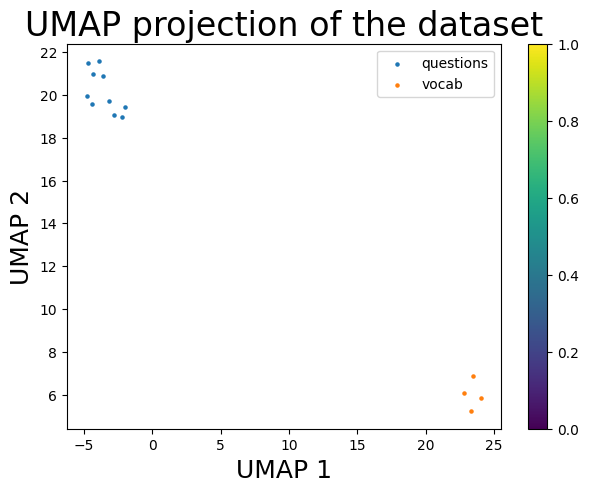

In [220]:
plt.figure(figsize=(7,5))
plt.scatter(umap_qst[:, 0], umap_qst[:, 1], cmap='Spectral', s=5, label="questions")
plt.scatter(umap_vocab[:, 0], umap_vocab[:, 1], cmap='Spectral', s=5, label="vocab")
plt.title('UMAP projection of the dataset', fontsize=24)
plt.xlabel('UMAP 1', fontsize=18)
plt.ylabel('UMAP 2', fontsize=18)
plt.colorbar()
plt.legend()
plt.show()

In [ ]:
umap_vocab = np.concatenate( (umap_vocab, umap_qst))

## Cluster

In [ ]:

cluster_qst = hdbscan.HDBSCAN(algorithm="best", 
                          min_cluster_size=2,
                          gen_min_span_tree = True,
                          metric='euclidean',       
                          cluster_selection_method = "eom").fit(umap_qst)
cluster_vocab = hdbscan.HDBSCAN(algorithm="best", 
                          min_cluster_size=2,
                          gen_min_span_tree = True,
                          metric='euclidean',       
                          cluster_selection_method = "eom").fit(umap_vocab)

In [ ]:
cluster_vocab.labels_.shape
# cluster_qst.probabilities_
# cluster_qst.cluster_persistence_
# cluster_qst.outlier_scores_
# cluster_qst.relative_validity_

(8,)

In [ ]:
result = pd.DataFrame(umap_vocab, columns=['x', 'y'])
result['labels'] = cluster_vocab.labels_


In [ ]:
clustered_qst = umap_qst[np.where(cluster_qst.labels_ != -1)]
clustered_vocab = umap_vocab[np.where(cluster_vocab.labels_ != -1)]

outliers_qst = umap_qst[np.where(cluster_qst.labels_ == -1)]
outliers_vocab = umap_vocab[np.where(cluster_vocab.labels_ == -1)]

labels = cluster_vocab.labels_[np.where(cluster_vocab.labels_ != -1)]

In [ ]:
if use_defs:
    vocab_app = np.concatenate((defs, questions))
else:
    vocab_app = np.concatenate((vocab, questions))

In [ ]:
print([ vocab_app[np.where(cluster_vocab.labels_ == i)] for i in range(-1, np.max(cluster_vocab.labels_)) ])

[array([], dtype='<U151'), array(['task initiation avoidance', 'excessive talkativeness ',
       'forgetfulness', 'non-planfulness'], dtype='<U151')]


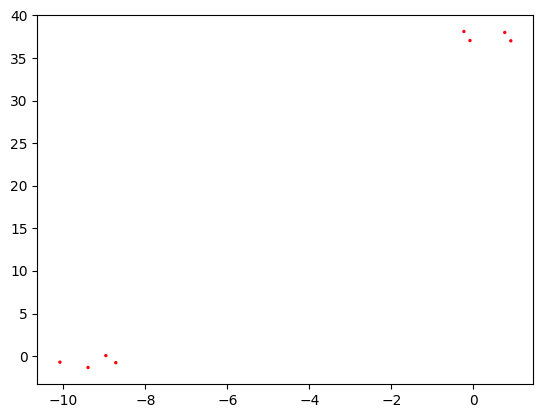

In [ ]:
plt.scatter(clustered_vocab[:,0], clustered_vocab[:,1], c=labels, s=2.0, cmap='hsv_r', label= "vocabulary")

In [ ]:

# # Visualize clusters
# fig, ax = plt.subplots(1,2, figsize=(10, 5))

# #plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.1)
# ax[0].scatter(clustered_qst[:,0], clustered_qst[:,1], c=cluster_qst.labels_, s=2.0, cmap='hsv_r')
# ax[1].scatter(clustered_vocab[:,0], clustered_vocab[:,1], c=cluster_vocab.labels_, s=2.0, cmap='hsv_r', label= "vocabulary")

# ax[0].set_title("questions")
# ax[1].set_title("vocabulary")
